# Tarea 4. Multiclasificación y regresión
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Descarga datos, haz clasificación y regresión a la vez.

Como podemos ver la tarea es simple y directa: tenemos un conjunto de datos de imágenes de personas con su edad, dos categorías de texto en la imagen y su sexo biológico.

Por lo que hay que hacer regresión con su edad y clasificación con las otras 3 categorías. (Varias clasificaciones, no multiclasificación en una sola)

In [1]:
import torch
import torch.nn as nn 
import torch.functional as F 
import fastai.vision.all as fv 
from fastai.metrics import accuracy, mse
from math import prod
from pathlib import Path
import os

Comenzamos con la función para tener el número de parámetros de cada modelo

In [2]:
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

Ahora vamos a trabajar con las imágenes antes de crear la función de load_data con todas las transformaciones y preprocesamiento correspondiente

In [3]:
os.listdir("faces")

['0_adios_mama_1_06101.jpg',
 '0_adios_gato_0_01644.jpg',
 '0_adios_mama_1_02290.jpg',
 '0_adios_gato_0_03778.jpg',
 '0_adios_mama_1_08504.jpg',
 '0_adios_gato_0_15888.jpg',
 '0_adios_mama_1_14978.jpg',
 '0_adios_gato_0_21347.jpg',
 '0_adios_mama_1_41577.jpg',
 '0_adios_gato_0_23496.jpg',
 '0_adios_mama_1_46191.jpg',
 '0_adios_gato_0_24303.jpg',
 '0_adios_mama_1_47600.jpg',
 '0_adios_gato_0_31689.jpg',
 '0_adios_mama_1_51337.jpg',
 '0_adios_gato_0_55729.jpg',
 '0_adios_mama_1_62000.jpg',
 '0_adios_gato_0_62758.jpg',
 '0_adios_papa_0_03135.jpg',
 '0_adios_gato_1_08248.jpg',
 '0_adios_papa_0_05989.jpg',
 '0_adios_gato_1_15140.jpg',
 '0_adios_papa_0_05998.jpg',
 '0_adios_gato_1_21763.jpg',
 '0_adios_papa_0_06423.jpg',
 '0_adios_gato_1_28672.jpg',
 '0_adios_papa_0_06447.jpg',
 '0_adios_gato_1_31579.jpg',
 '0_adios_papa_0_08835.jpg',
 '0_adios_gato_1_34700.jpg',
 '0_adios_papa_0_11964.jpg',
 '0_adios_gato_1_40576.jpg',
 '0_adios_papa_0_14944.jpg',
 '0_adios_gato_1_52330.jpg',
 '0_adios_papa

El siguiente paso es muy importante: vamos a extraer las etiquetas y el valor de la regresión. Esto fue de las cosas que más trabajo nos dio y no por la dificultad de la función, sino porque no sabíamos que debíamos hacer una función para cada cosa (no una para todas y que nos regrese una lista)

In [3]:
def obtener_edad(f):
    return float(f.stem.split("_")[0])

def obtener_cat1(f):
    return f.stem.split("_")[1]

def obtener_cat2(f):
    return f.stem.split("_")[2]

def obtener_sexo(f):
    return f.stem.split("_")[3]

Veamos si con esto podemos cargar y formar los batches

In [4]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(flip_vert=False, # no vamos a voltear las caras de las personas porque no beneficia en este caso
                            max_rotate=30, # poca rotación, solamente para que la red aprenda mejor
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.05) # queremos poca distorción

    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.RegressionBlock, fv.CategoryBlock, fv.CategoryBlock, fv.CategoryBlock), # a esto me refería de que cada cosa era independiente: la regresión y las 3 clasificaciones 
                        n_inp     = 1, # es de un solo bloque (el de imagen) del que recibe inputs
                        get_items = fv.get_image_files,
                        get_y     = (obtener_edad, obtener_cat1, obtener_cat2, obtener_sexo), # esto tambien fue fundamental (porer las listas de las funciones que nos darán etiquetas)
                        splitter  = fv.RandomSplitter(0.3),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms)
    
    return data.dataloaders(folder, batch_size=batch_size)

In [5]:
data = load_data("faces", 256, 128)

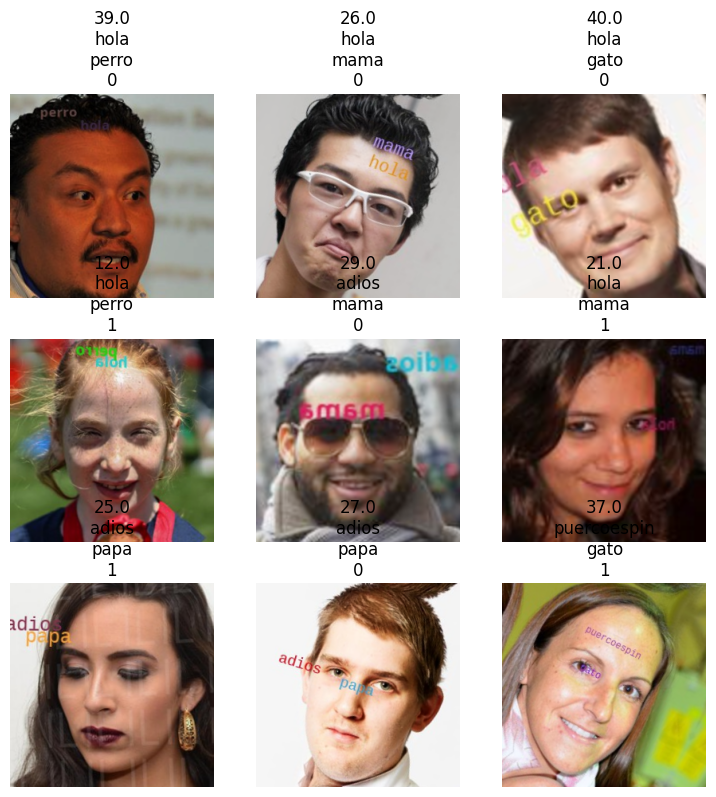

In [7]:
data.show_batch()

In [8]:
X, edad, cat1, cat2, sex = data.one_batch()

In [9]:
X.shape

torch.Size([128, 3, 256, 256])

In [10]:
edad.shape

torch.Size([128])

In [11]:
cat1

TensorCategory([2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 1,
                0, 2, 1, 1, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0,
                1, 0, 1, 0, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2,
                0, 0, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1,
                2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 1, 2, 2, 0, 1, 1, 0, 2,
                0, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0, 0,
                1, 2], device='cuda:0')

In [12]:
cat2

TensorCategory([0, 2, 0, 2, 2, 2, 0, 3, 0, 0, 3, 3, 3, 2, 0, 3, 2, 2, 1, 1, 3,
                1, 0, 0, 0, 1, 3, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 3, 2, 0, 0, 0,
                0, 2, 2, 0, 0, 0, 3, 1, 0, 2, 2, 0, 1, 2, 0, 3, 0, 3, 2, 0, 3,
                1, 0, 1, 3, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 3, 3, 1, 1, 2, 3, 0,
                0, 1, 2, 3, 0, 1, 1, 0, 1, 1, 3, 3, 1, 2, 3, 1, 3, 0, 3, 2, 2,
                3, 2, 3, 0, 1, 0, 0, 2, 3, 3, 1, 0, 3, 2, 3, 2, 0, 2, 3, 1, 2,
                3, 3], device='cuda:0')

Como podemos ver hay 3 etiquetas para la primera categoría y 4 para la segunda

In [13]:
sex

TensorCategory([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
                0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
                0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
                0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
                0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
                1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
                1, 0], device='cuda:0')

Ahora sí vamos con la parte más importante: definir nuestra función de pérdida. Esto porque en el entrenamiento no queremos que la red solamente ajuste las edades y las otras categorías las ignore (o viceversa)

In [6]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return mse(yp[:,0], edad) + 0.5 * (cl1(yp[:,1:4], cat1) + cl2(yp[:,4:8], cat2) + cl3(yp[:,8:], sexo))

Como podemos ver es super importante asignar los pesos para cada sección para que no estén desbalanceadas, es decir, permitirle a la red optimizar ambas partes y no sólo una. Igual podemos hacer varios experimentos con diferentes pesos para esta función

Ahora sí, vamos a definir el modelo con todo lo que hemos hecho. Vamos a usar una resnet para trabajar 

In [7]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean= torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [8]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, # pongo la regularización porque me han estado explotando los gradientes porque mi pérdida crece demasiado
                              normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

Y así como definimos las formas de sacar las etiquetas y valor, al igual que la función de pérdida, vamos a programar nuestras métricas (porque si las damos por default nos marca errores al entrenar). Esta parte de hacer las pérdidas me causó muchos problemas porque no sabía que Pytorch regresa todas las decisiones de la red para evaluarla. Esto es, tenemos que seleccionar cuál tomar para cada métrica

In [9]:
def mse_edad(pred, edad, categoria1, categoria2, sexo):
    return mse(pred[:, 0], edad)**0.5

def accuracy_cat1(pred, edad, categoria1, categoria2, sexo):
    return accuracy(pred[:, 1:4], categoria1)

def accuracy_cat2(pred, edad, categoria1, categoria2, sexo):
    return accuracy(pred[:, 4:8], categoria2)

def accuracy_sexo(pred, edad, categoria1, categoria2, sexo):
    return accuracy(pred[:, 8:], sexo)


In [10]:
learn1 = create_learner(metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo])

SuggestedLRs(valley=0.015848932787775993)

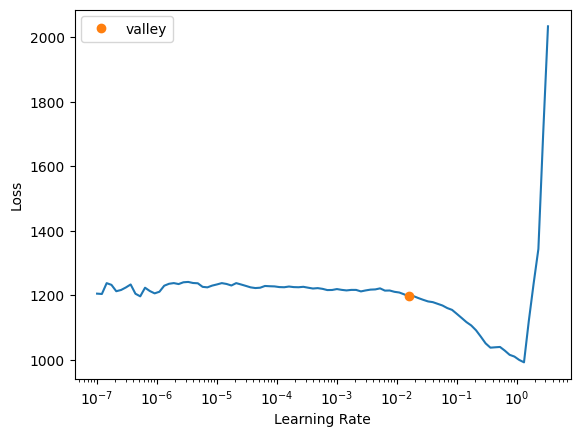

In [11]:
learn1.lr_find()

Y mandamos entrenar nuestro primer modelo

In [12]:
learn1.fit_one_cycle(12, 0.015, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,440.032471,214.317520,14.564153,0.353117,0.256921,0.619399,00:15
1,228.823990,184.065201,13.478307,0.354312,0.244772,0.620793,00:15
2,168.741211,128.042221,11.199580,0.358295,0.256722,0.669189,00:15
3,141.400635,148.717361,12.110058,0.341167,0.253734,0.674567,00:15
4,125.024231,139.657913,11.721490,0.351125,0.262498,0.638717,00:15
5,114.462982,219.244827,14.728655,0.334396,0.254929,0.636327,00:15
6,106.276604,88.918854,9.318233,0.351922,0.248755,0.644294,00:14
7,102.415695,85.282593,9.117315,0.348735,0.249950,0.700856,00:15
8,93.030678,120.835876,10.878355,0.359888,0.249552,0.724358,00:15
9,89.023674,88.474899,9.291586,0.340171,0.256323,0.726748,00:14


¡Por fin logramos que entrenara! Y en cuanto a la edad y el sexo lo hace bastante bien: llegando a un error de 8 años y adivinando el sexo de las personas en casi el 75% de las veces. 

Sin embargo, en las categorías adicionales le está costando mucho trabajo. Prácticamente en la función de pérdida no tienen peso porque lo que hace la red es predecir la clase con más instancias en cada categoría (memoriza los datos más abundantes).ipynb_checkpoints/

Vamos a probar sin tocar el peso de las variables a clasificar.

In [13]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return mse(yp[:,0], edad) + cl1(yp[:,1:4], cat1) + cl2(yp[:,4:8], cat2) + cl3(yp[:,8:], sexo)

In [14]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-2, # bajamos la regularización esperando que no explote
                              normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [15]:
learn2 = create_learner(metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo])

SuggestedLRs(valley=0.02290867641568184)

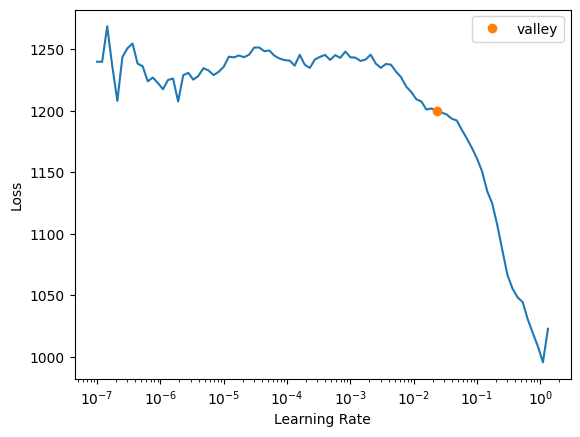

In [16]:
learn2.lr_find()

In [17]:
learn2.fit_one_cycle(12, 0.008, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,501.316772,209.639740,14.333680,0.388767,0.255925,0.767974,00:14
1,181.567795,80.548042,8.782351,0.393547,0.252938,0.783708,00:14
2,112.456810,68.851303,8.094944,0.377216,0.256323,0.794463,00:14
3,89.124443,76.500015,8.556691,0.360088,0.257518,0.796057,00:14
4,79.282555,72.087242,8.282277,0.378809,0.252141,0.795857,00:13
5,71.029251,52.064411,6.985242,0.343756,0.253535,0.839275,00:14
6,65.007675,71.576057,8.260149,0.379008,0.254531,0.846047,00:13
7,63.321014,82.987007,8.917613,0.366859,0.254332,0.853416,00:13
8,60.904667,48.798218,6.749056,0.369647,0.254531,0.856204,00:13
9,54.843796,46.804493,6.597126,0.367855,0.253535,0.834097,00:14


Como podemos ver la edad y el sexo tiene un desempeño muy bueno! Subimos el sexo de las personas hasta el 87% y el error en la edad se redujo a 6 años. En cuanto a las categorías adicionales parece que en la primera aprendió un poquito, pero para la segunda siguen igual.

Esto nos indica que dentro de la función de pérdida necesitamos darles más peso a estas categorías

In [18]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return mse(yp[:,0], edad) + (3 * (cl1(yp[:,1:4], cat1) + cl2(yp[:,4:8], cat2))) + cl3(yp[:,8:], sexo) # Hacemos que las categorías pesen 3 veces más

In [19]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [20]:
learn3 = create_learner()

SuggestedLRs(valley=0.010964781977236271)

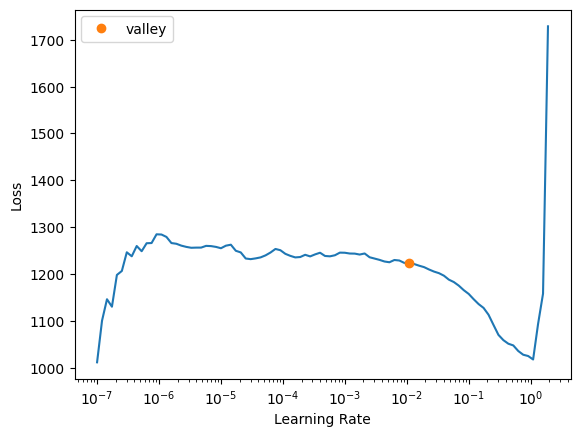

In [21]:
learn3.lr_find()

In [22]:
learn3.fit_one_cycle(15, 0.02, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,439.927490,226.276993,14.737262,0.347142,0.245170,0.632742,00:13
1,227.362595,190.274582,13.435731,0.351723,0.242581,0.629357,00:14
2,180.614685,281.136292,16.464899,0.329217,0.266481,0.649273,00:14
3,154.229828,157.914490,12.178115,0.335391,0.249353,0.671779,00:14
4,141.830170,138.749466,11.369851,0.333997,0.241984,0.693288,00:14
5,131.114182,173.520798,12.791822,0.330213,0.254531,0.671978,00:14
6,125.829597,133.885712,11.179777,0.350329,0.252938,0.713802,00:14
7,122.431816,125.087730,10.724455,0.332802,0.249950,0.716590,00:14
8,118.890808,113.471443,10.187528,0.348536,0.256124,0.578968,00:14
9,112.311615,114.260155,10.253804,0.341765,0.244971,0.703446,00:14


Logramos que subiera muy poco la categoría 1, pero a costo de perder en la edad y el sexo. Además, la categoría 2 sigue sin mejorar. Solamente como comprobación vamos a silecionar la edad y el sexo para ver si así aprende mejor o si es un error de estas categorías

In [31]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return cl1(yp[:,1:4], cat1) + cl2(yp[:,4:8], cat2)

In [32]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [33]:
learn4 = create_learner()

SuggestedLRs(valley=0.0831763744354248)

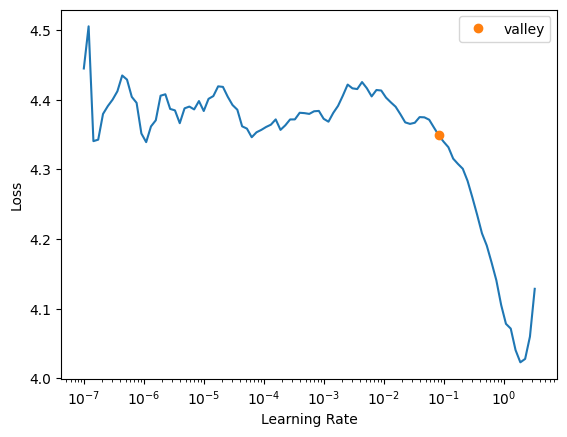

In [34]:
learn4.lr_find()

In [35]:
learn4.fit_one_cycle(15, 0.08, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,3.233552,2.575710,35.985397,0.460267,0.260108,0.480382,00:14
1,2.407408,2.047992,35.439316,0.649871,0.322645,0.492133,00:14
2,2.082731,2.019888,35.607136,0.675563,0.372834,0.519418,00:13
3,1.862208,1.793255,35.374882,0.685521,0.492731,0.543517,00:14
4,1.666964,1.718578,36.116337,0.759012,0.520016,0.519618,00:14
5,1.546754,1.201418,36.589077,0.827524,0.675164,0.539136,00:14
6,1.453653,1.223193,35.901901,0.800637,0.704840,0.518024,00:14
7,1.403390,1.171670,35.820972,0.833898,0.695877,0.515634,00:14
8,1.374346,1.236536,35.888149,0.815973,0.670185,0.532962,00:14
9,1.349629,1.210916,36.070713,0.834296,0.665206,0.525991,00:14


Como podemos ver sí que la red puede aprender estas dos categorías. En la 1 alcanzó 88% en su mejor época y 77% en la 2. Esto quiere decir que aun no encontramos el balance adecuado

In [36]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return mse(yp[:,0], edad) + cl3(yp[:,8:], sexo) + (7 * cl1(yp[:,1:4], cat1)) + (10 * cl2(yp[:,4:8], cat2))

In [37]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, #wd=1e-4, quitamos la regularización para ver si logramos que no explote con un lr correcto
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [38]:
learn5 = create_learner()

SuggestedLRs(valley=0.019054606556892395)

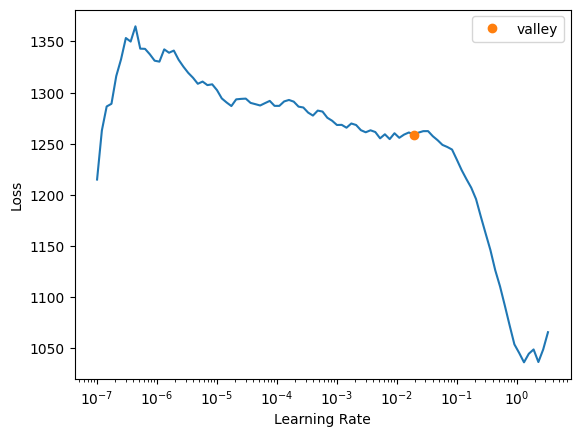

In [39]:
learn5.lr_find()

In [40]:
learn5.fit_one_cycle(15, 0.2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,304.683990,301.931305,16.473818,0.340769,0.251544,0.555666,00:14
1,204.228973,152.837021,11.306441,0.340968,0.252938,0.651464,00:14
2,174.326050,151.180695,11.202182,0.345549,0.255726,0.620992,00:14
3,162.135849,146.925842,10.996894,0.350528,0.240988,0.671978,00:14
4,154.928741,174.691986,12.203203,0.347142,0.253734,0.635730,00:14
5,152.361893,172.386246,12.119291,0.350926,0.238996,0.626568,00:14
6,155.251358,225.371643,14.153732,0.350129,0.247759,0.655049,00:14
7,145.670029,181.305984,12.471861,0.346744,0.256921,0.563234,00:14
8,146.285782,131.105484,10.359933,0.344354,0.243577,0.663414,00:14
9,140.937683,269.372589,15.632701,0.341565,0.252539,0.603864,00:13


Como vemos no fueron buenos pesos porque ahora solamente empeoró de la edad y sexo, mientras que las otras categorías volvió a no aprenderlas (solamente predice siempre la categoría más frecuente)

In [41]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return (0.1 * mse(yp[:,0], edad)) + (0.5 * cl3(yp[:,8:], sexo)) + (7 * cl1(yp[:,1:4], cat1)) + (10 * cl2(yp[:,4:8], cat2))

In [42]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [43]:
learn6 = create_learner()

SuggestedLRs(valley=0.03981071710586548)

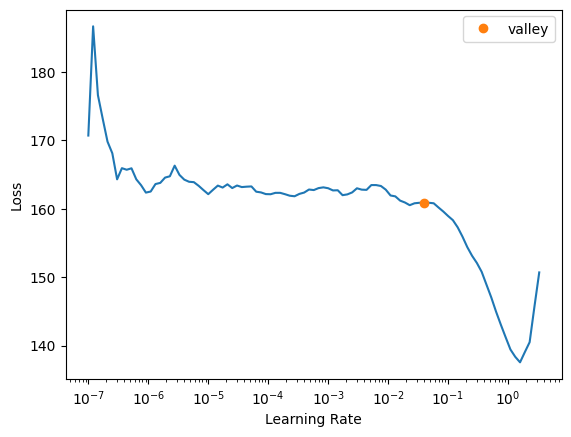

In [44]:
learn6.lr_find()

In [45]:
learn6.fit_one_cycle(12, 0.09, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,81.384155,50.455807,16.360613,0.356104,0.238797,0.542920,00:14
1,54.499786,40.270920,13.077184,0.369448,0.252938,0.554471,00:14
2,45.131142,35.785297,11.359592,0.407887,0.246365,0.617407,00:14
3,42.517319,32.815628,10.465117,0.456284,0.247560,0.672774,00:13
4,40.514881,32.186012,10.324525,0.528381,0.268273,0.683927,00:14
5,39.511665,34.321251,11.680162,0.562637,0.251942,0.657837,00:14
6,38.950024,45.418293,14.593410,0.484963,0.270066,0.641904,00:14
7,38.253117,32.554142,10.488419,0.543318,0.275244,0.680542,00:13
8,37.963078,32.514874,11.063173,0.582752,0.264489,0.663613,00:13
9,36.990948,31.177536,10.132743,0.572794,0.276638,0.700458,00:14


Como vemos la regresión sigue funcionando muy bien, el sexo bajo un poco aunque llega al 70% y por fin logramos subir la categoría 1 a un accuracy decente. La categoría 2 sí mejoró también, pero sigue en porcentajes más bajos. Así que vamos a mejorar la función de pérdida anterior y vamos a manter la regularización en el modelo

In [46]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return (0.1 * mse(yp[:,0], edad)) + (0.7 * cl3(yp[:,8:], sexo)) + (8 * cl1(yp[:,1:4], cat1)) + (16 * cl2(yp[:,4:8], cat2))

In [47]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [48]:
learn7 = create_learner()

SuggestedLRs(valley=0.04786301031708717)

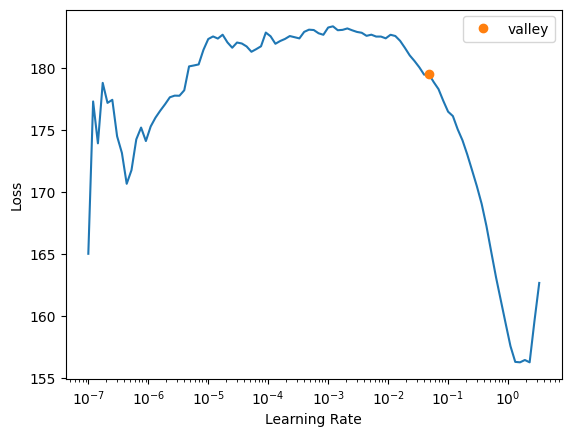

In [49]:
learn7.lr_find()

In [50]:
learn7.fit_one_cycle(12, 0.05, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,119.750496,79.150757,20.873257,0.361880,0.248158,0.499701,00:14
1,80.554436,58.022648,15.844173,0.378809,0.250548,0.544513,00:14
2,65.713120,50.625179,13.600266,0.394145,0.260108,0.646684,00:14
3,58.708069,44.079350,11.275732,0.461263,0.259311,0.629158,00:14
4,55.537701,45.429253,12.006675,0.478988,0.254332,0.655447,00:14
5,54.153450,59.433865,14.507058,0.414061,0.263892,0.609241,00:14
6,52.994984,51.745605,13.659808,0.499502,0.272456,0.655646,00:14
7,51.793884,59.868862,17.323027,0.571599,0.273651,0.646286,00:14
8,51.103489,56.520500,16.383850,0.574188,0.289584,0.655049,00:14
9,49.836697,52.467369,15.038034,0.549890,0.284007,0.698666,00:14


Llegamos a casi idénticos resultados que en el modelo anterior, pero subiendo un poco el accuracy de la categoría 2

In [51]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return (0.25 * mse(yp[:,0], edad)) + ( cl3(yp[:,8:], sexo)) + (8 * cl1(yp[:,1:4], cat1)) + (32 * cl2(yp[:,4:8], cat2))

In [52]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [53]:
learn8 = create_learner()

SuggestedLRs(valley=0.02290867641568184)

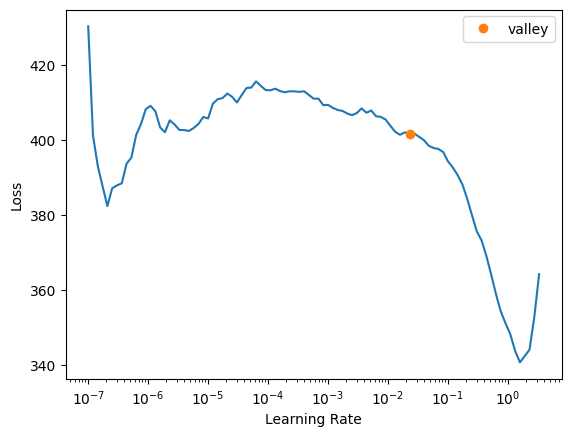

In [54]:
learn8.lr_find()

In [55]:
learn8.fit_one_cycle(15, 0.2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,164.808136,128.343460,16.911711,0.354710,0.247759,0.546704,00:14
1,132.557526,108.907799,14.300179,0.356702,0.248158,0.560645,00:14
2,118.119453,117.831299,15.420454,0.338976,0.243975,0.561243,00:13
3,112.211578,96.326553,12.495039,0.349930,0.257718,0.676160,00:14
4,109.810844,102.912178,13.560275,0.352918,0.251743,0.629954,00:14
5,109.483208,102.663544,11.958413,0.341964,0.238598,0.598885,00:14
6,109.996674,91.020561,11.364864,0.342760,0.260705,0.673372,00:14
7,108.212761,88.778603,11.017593,0.347540,0.248556,0.621191,00:14
8,107.374840,105.896820,13.617500,0.359291,0.255527,0.671380,00:14
9,105.720856,86.482285,10.821169,0.342163,0.248357,0.655646,00:14


Estos últimos pesos fueron bastante malos, por lo que como último intento mejor tomaremos el mejor modelo y entrenemos 100 épocas

In [56]:
def perdida_combinada(yp, edad, cat1, cat2, sexo):
    mse = nn.MSELoss()
    cl1 = nn.CrossEntropyLoss()
    cl2 = nn.CrossEntropyLoss()
    cl3 = nn.CrossEntropyLoss()
    return (0.1 * mse(yp[:,0], edad)) + (0.7 * cl3(yp[:,8:], sexo)) + (8 * cl1(yp[:,1:4], cat1)) + (16 * cl2(yp[:,4:8], cat2))

In [57]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, n_out=10,
                              loss_func=perdida_combinada,
                              opt_func=fv.ranger, wd=1e-4, 
                              normalize=False, 
                              metrics=[mse_edad, accuracy_cat1, accuracy_cat2, accuracy_sexo],
                              **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [58]:
learn100 = create_learner()

SuggestedLRs(valley=0.04786301031708717)

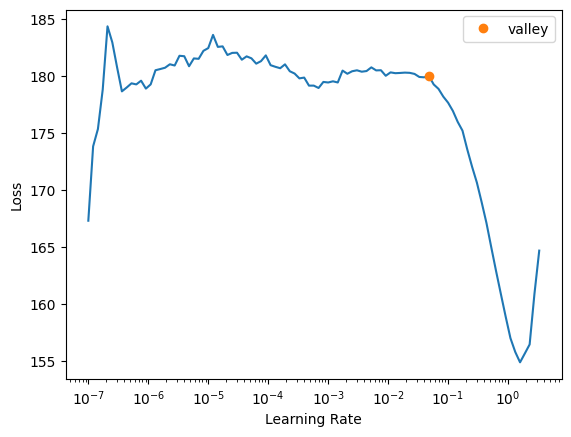

In [59]:
learn100.lr_find()

In [60]:
learn100.fit_one_cycle(100, 0.08, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,mse_edad,accuracy_cat1,accuracy_cat2,accuracy_sexo,time
0,100.899117,64.911087,17.764915,0.350528,0.259510,0.549890,00:14
1,71.063454,54.742985,14.964843,0.366262,0.256921,0.648277,00:14
2,61.411255,84.694756,22.888046,0.379008,0.242780,0.562239,00:14
3,57.383415,47.670174,12.250509,0.393348,0.260506,0.567616,00:14
4,55.691521,48.902943,13.468716,0.489544,0.253535,0.684326,00:14
5,53.849319,46.194550,12.475049,0.502091,0.259709,0.659231,00:14
6,53.140041,49.367302,13.894353,0.550289,0.264091,0.684326,00:14
7,52.501915,60.534500,17.107803,0.542920,0.256523,0.619399,00:13
8,51.862274,48.000790,13.471243,0.584545,0.260307,0.641506,00:14
9,51.289982,43.298206,11.355709,0.531966,0.270265,0.675164,00:14


Después de 100 épocas logramos subir las métricas a 68% para la categoría 1, 57% para la categoría 2 y casi 70% para el sexo. La edad en la regresión la reducimos hasta los 9 años y medio.

¡Qué bonito queda con bastante poder de GPU! :)